In [1]:
%load_ext autoreload
%autoreload 2

In [71]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
import numpy as np 

from gptchem.data import get_polymer_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx

%matplotlib inline

In [72]:
all_res = glob("out/**/*.pkl")

In [73]:
res = load_pickle(all_res[1])

In [74]:
temperatures = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [75]:
compiled_res = []

for filename in all_res: 
    loaded = load_pickle(filename)
    try:
        for i, res in enumerate(loaded['res']):
            result = {
                'num_train_points': loaded['num_train_points'],
                'noise_level': loaded['noise_level'],
                'valid_fraction': res['valid_smiles_fraction'],
                'unique_fraction': res['unique_smiles_fraction'],
                'temp': temperatures[i],
                'kldiv_score': res['kldiv_score'],
                'mae': np.mean(res['losses']),
                **res['string_distances_collection_summary']
            }
            for k,v in res['summary_composition_mismatches'].items():
                result[f'comp_mismatch_{k}'] = v
        
            compiled_res.append(result)
    except Exception as e :
        print(e)
        pass
        

'res'
'res'


In [76]:
df = pd.DataFrame(compiled_res)

In [77]:
grouped = df.groupby(['num_train_points', 'temp']).agg(['mean', 'std'])

In [78]:
grouped['LongestCommonSubsequence_mean']

mean         std
num_train_points temp                        
100              0.00  310.567222  257.763878
                 0.10  211.334630  291.481913
                 0.20  102.073519  104.347492
                 0.50   41.199815    1.823854
                 0.75   44.155556    4.179787
                 1.00   51.900000   16.829141

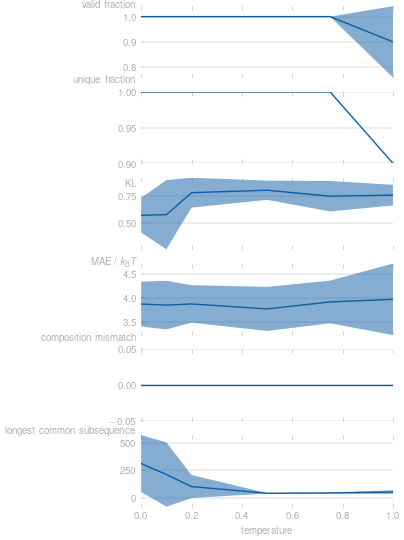

In [79]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(6,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))

    ax[0].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
    ax[0].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['valid_fraction']['mean'] -  grouped.loc[100, :]['valid_fraction']['std'], 
        grouped.loc[100, :]['valid_fraction']['mean'] +  grouped.loc[100, :]['valid_fraction']['std'], alpha=.5 )
    matplotx.ylabel_top('valid fraction', ax=ax[0])


    ax[1].plot(grouped.loc[100, :].index, grouped.loc[100, :]['valid_fraction']['mean'])
    ax[1].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['unique_fraction']['mean'] -  grouped.loc[100, :]['unique_fraction']['std'], 
        grouped.loc[100, :]['unique_fraction']['mean'] +  grouped.loc[100, :]['unique_fraction']['std'], alpha=.5 )
    matplotx.ylabel_top('unique fraction', ax=ax[1])

    ax[2].plot(grouped.loc[100, :].index, grouped.loc[100, :]['kldiv_score']['mean'])
    ax[2].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['kldiv_score']['mean'] -  grouped.loc[100, :]['kldiv_score']['std'], 
        grouped.loc[100, :]['kldiv_score']['mean'] +  grouped.loc[100, :]['kldiv_score']['std'], alpha=.5 )
    matplotx.ylabel_top('KL', ax=ax[2])

    ax[3].plot(grouped.loc[100, :].index, grouped.loc[100, :]['mae']['mean'])
    ax[3].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['mae']['mean'] -  grouped.loc[100, :]['mae']['std'], 
        grouped.loc[100, :]['mae']['mean'] +  grouped.loc[100, :]['mae']['std'], alpha=.5 )
    matplotx.ylabel_top('MAE / $k_\mathrm{B}T$', ax=ax[3])

    ax[4].plot(grouped.loc[100, :].index, grouped.loc[100, :]['comp_mismatch_mean']['mean'])
    ax[4].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['comp_mismatch_mean']['mean'] -  grouped.loc[100, :]['comp_mismatch_mean']['std'], 
        grouped.loc[100, :]['comp_mismatch_mean']['mean'] +  grouped.loc[100, :]['comp_mismatch_mean']['std'], alpha=.5 )
    matplotx.ylabel_top('composition mismatch', ax=ax[4])


    ax[5].plot(grouped.loc[100, :].index, grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'])
    ax[5].fill_between(
       grouped.loc[100, :].index,
        grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] -  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], 
        grouped.loc[100, :]['LongestCommonSubsequence_mean']['mean'] +  grouped.loc[100, :]['LongestCommonSubsequence_mean']['std'], alpha=.5 )
    matplotx.ylabel_top('longest common subsequence', ax=ax[5])

    ax[-1].set_xlabel('temperature', labelpad=4)
    fig.savefig('random_polymer_inverse.pdf', bbox_inches='tight')

In [68]:
np.abs(get_polymer_data()['deltaGmin'].mean() - get_polymer_data()['deltaGmin']).mean()

2.7135963497608304